In [37]:
import os
import cv2
import numpy as np

# Replace with your actual path to the Flower-102 dataset directory
dataset_directory = 'C://Users//owner//CUPS'#http://localhost:8888/tree/BUENOS_AIRES_LUNGO

images = []
labels = []

for class_folder in os.listdir(dataset_directory):
    class_path = os.path.join(dataset_directory, class_folder)
    if os.path.isdir(class_path):
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            img = cv2.imread(image_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB if needed
                img = cv2.resize(img, (64, 64))  # Resize images as needed
                images.append(img)
                labels.append(class_folder)  # Assign labels based on folder names

# Convert lists to NumPy arrays if necessary
images = np.array(images)
labels = np.array(labels)


In [38]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Normalize pixel values between 0 and 1 for both train and test sets (if needed)
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0


In [39]:
train_images.shape

(293, 64, 64, 3)

In [40]:
from tensorflow import keras
from tensorflow.keras import layers

encoding_dim = 32  # Set your desired encoding dimension

# Define the new input shape for smaller images (64x64x3)
input_img = keras.Input(shape=(64 * 64 * 3,))  # For 64x64 images

# Encoder layers
encoded = layers.Dense(8192, activation='relu')(input_img)  # Adjust the number of neurons to handle the reduced input size
encoded = layers.Dense(4096, activation='relu')(encoded)
encoded = layers.Dense(2048, activation='relu')(encoded)
encoded = layers.Dense(1024, activation='relu')(encoded)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

# Decoder layers
decoded = layers.Dense(1024, activation='relu')(encoded)
decoded = layers.Dense(2048, activation='relu')(decoded)
decoded = layers.Dense(4096, activation='relu')(decoded)
decoded = layers.Dense(8192, activation='relu')(decoded)
decoded = layers.Dense(64 * 64 * 3, activation='sigmoid')(decoded)  # Output layer for the smaller image size

autoencoder = keras.Model(input_img, decoded)

# Extracting the encoder and decoder parts as separate models (unchanged)
encoder = keras.Model(input_img, encoded)
encoded_input = keras.Input(shape=(encoding_dim,))
decoder_layers = autoencoder.layers[-5:]
decoder_output = encoded_input
for layer in decoder_layers:
    decoder_output = layer(decoder_output)
decoder = keras.Model(encoded_input, decoder_output)

autoencoder = keras.Model(input_img, decoded)

# Extracting the encoder and decoder parts as separate models
encoder = keras.Model(input_img, encoded)

# Extracting the decoder part
encoded_input = keras.Input(shape=(encoding_dim,))
decoder_layers = autoencoder.layers[-5:]  # Decoder layers including the last one
decoder_output = encoded_input
for layer in decoder_layers:
    decoder_output = layer(decoder_output)
decoder = keras.Model(encoded_input, decoder_output)


In [41]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


In [42]:
def add_gaussian_noise(images, noise_factor=0.1): #It controls how much the random Gaussian noise affects the images.
    mu = 0  # Set your desired mean
    sigma = 1  # Set your desired standard deviation
    noisy_images = images + noise_factor * (sigma * np.random.randn(*images.shape) + mu)
    #noisy_images = images + noise_factor * np.random.randn(*images.shape)
    noisy_images = np.clip(noisy_images, 0.0, 1.0)  # Clip values to stay within [0, 1] range
    return noisy_images


In [43]:
train_images = train_images.reshape((len(train_images), np.prod(train_images.shape[1:])))
test_images = test_images.reshape((len(test_images), np.prod(test_images.shape[1:])))
print(train_images.shape)
print(test_images.shape)
noise_factor = 0.2  # Adjust the noise factor as needed
noisy_train_images = add_gaussian_noise(train_images, noise_factor)
noisy_test_images = add_gaussian_noise(test_images, noise_factor)

(293, 12288)
(74, 12288)


In [44]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(noisy_train_images, train_images, epochs=70, batch_size=128, shuffle=True)


Epoch 1/70
3/3 [==============================] - 9s 2s/step - loss: 0.6916
Epoch 2/70
3/3 [==============================] - 7s 2s/step - loss: 0.6861
Epoch 3/70
3/3 [==============================] - 6s 2s/step - loss: 0.7638
Epoch 4/70
3/3 [==============================] - 6s 2s/step - loss: 0.6911
Epoch 5/70
3/3 [==============================] - 6s 2s/step - loss: 0.6937
Epoch 6/70
3/3 [==============================] - 6s 2s/step - loss: 0.6869
Epoch 7/70
3/3 [==============================] - 6s 2s/step - loss: 0.6723
Epoch 8/70
3/3 [==============================] - 6s 2s/step - loss: 0.6604
Epoch 9/70
3/3 [==============================] - 6s 2s/step - loss: 0.6607
Epoch 10/70
3/3 [==============================] - 6s 2s/step - loss: 0.6594
Epoch 11/70
3/3 [==============================] - 6s 2s/step - loss: 0.6603
Epoch 12/70
3/3 [==============================] - 7s 2s/step - loss: 0.6524
Epoch 13/70
3/3 [==============================] - 6s 2s/step - loss: 0.6477
Epoch 14

In [45]:
# Reconstruction using the trained autoencoder
encoded_imgs = encoder.predict(test_images)
decoded_imgs = decoder.predict(encoded_imgs)

3/3 [==============================] - 3s 36ms/step


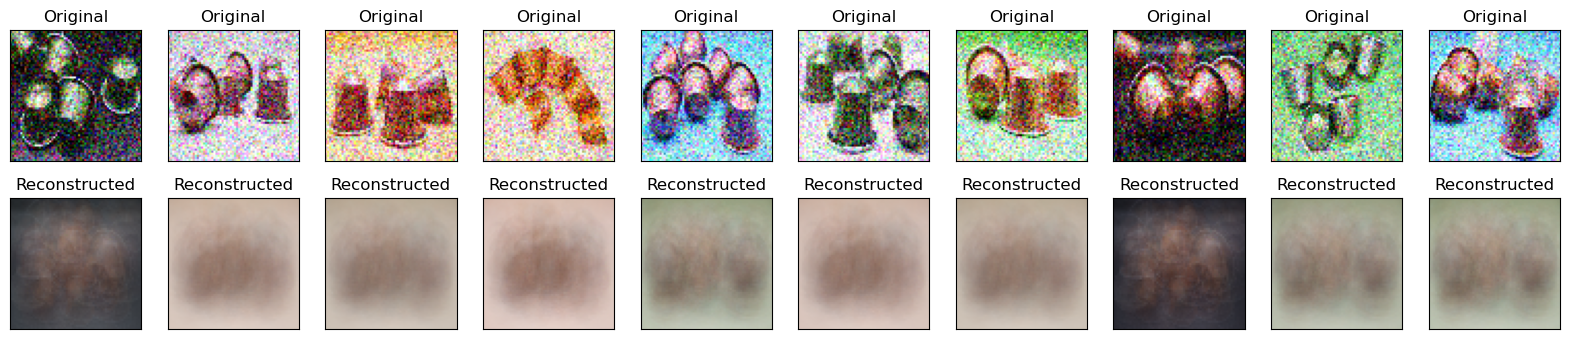

In [46]:
import matplotlib.pyplot as plt

# Plotting the original and reconstructed images
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(noisy_test_images[i].reshape(64, 64, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Original")

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(64, 64, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Reconstructed")
plt.show()

In [47]:
# Model compilation and training remain unchanged
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(train_images, train_images, epochs=70, batch_size=128, shuffle=True)

# Reconstruction using the trained autoencoder
encoded_imgs2 = encoder.predict(noisy_test_images)
decoded_imgs2 = decoder.predict(encoded_imgs2)


Epoch 1/70
3/3 [==============================] - 11s 2s/step - loss: 1.0749
Epoch 2/70
3/3 [==============================] - 7s 2s/step - loss: 0.7709
Epoch 3/70
3/3 [==============================] - 7s 2s/step - loss: 0.6729
Epoch 4/70
3/3 [==============================] - 7s 2s/step - loss: 0.6583
Epoch 5/70
3/3 [==============================] - 7s 2s/step - loss: 0.6566
Epoch 6/70
3/3 [==============================] - 6s 2s/step - loss: 0.6439
Epoch 7/70
3/3 [==============================] - 7s 2s/step - loss: 0.6405
Epoch 8/70
3/3 [==============================] - 7s 2s/step - loss: 0.6368
Epoch 9/70
3/3 [==============================] - 6s 2s/step - loss: 0.6292
Epoch 10/70
3/3 [==============================] - 6s 2s/step - loss: 0.6600
Epoch 11/70
3/3 [==============================] - 6s 2s/step - loss: 0.6560
Epoch 12/70
3/3 [==============================] - 6s 2s/step - loss: 0.6673
Epoch 13/70
3/3 [==============================] - 6s 2s/step - loss: 0.6582
Epoch 1

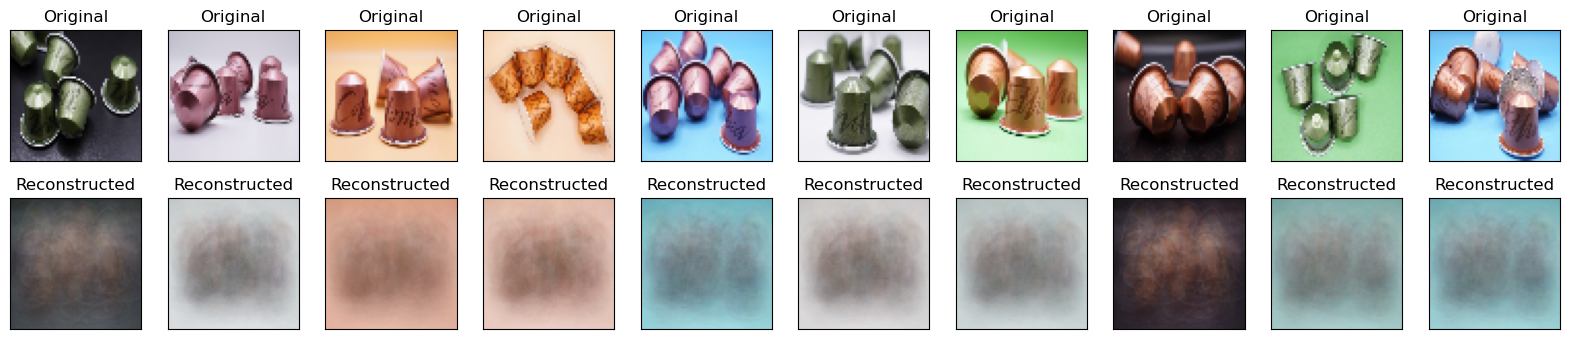

In [48]:
# Plotting the original and reconstructed images
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i].reshape(64, 64, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Original")

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs2[i].reshape(64, 64, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Reconstructed")
plt.show()